In [16]:
import pandas as pd
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

In [40]:
run_folders = ['../../output/run1/validation/summary-statistics', '../../output/run2/validation/summary-statistics', 
               '../../output/run3/validation/summary-statistics', '../../output/run4/validation/summary-statistics',
               '../../output/run5/validation/summary-statistics', '../../output/run6/validation/summary-statistics', 
               '../../output/run7/validation/summary-statistics', '../../output/run8/validation/summary-statistics',
               '../../output/run9/validation/summary-statistics', '../../output/run10/validation/summary-statistics']

graph_types = ['summary_observation', 'summary_action']
metrics = ['Class_Compliance', 'Property_Compliance', 'Class_Coverage', 'Property_Coverage']

llm_colors = {
    'llava-llama3': '#e9c46a',
    'llama4-scout': '#f4a261',
    'llama4-maverick': '#e76f51',
    'gpt-4.1-nano': '#2a9d8f',
    'gpt-o1': '#264653',
}

In [41]:
all_dfs = []
pattern = r'output/([^/]+)/.*/([^/]+)/[^/]+$'

for run_index, folder in enumerate(run_folders, start=1):
    for graph_type in graph_types:
        file_path = os.path.join(folder, f"{graph_type}.csv")
        df = pd.read_csv(file_path, header=0)
        df.rename(columns={df.columns[0]: 'file_path'}, inplace=True)
        models = []
        methods = []
        
        for fp in df['file_path'].astype(str):
            match = re.search(pattern, fp)
            if match:
                models.append(match.group(1))
                methods.append(match.group(2))
            else:
                print(f"No pattern match for file_path: {fp} (in {file_path})")
                models.append(None)
                methods.append(None)
        
        df['model'] = models
        df['method'] = methods
        df['graph_type'] = graph_type.replace("summary_", "")
        df['run'] = run_index

        for metric in metrics: 
            numer = df[metric].str.split('/', expand=True)[0].astype(float)
            denom = df[metric].str.split('/', expand=True)[1].astype(float)
            df[metric] = np.where(denom == 0, 0, numer / denom)

        cols_order = ['run', 'model', 'graph_type', 'method'] + [
            c for c in df.columns if c not in ['run', 'model', 'graph_type', 'method', 'file_path']
        ]
        df = df[cols_order]
        
        all_dfs.append(df)

merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df.to_csv('../../output/summary-statistics/merged_summary_statistics.csv', index=False)

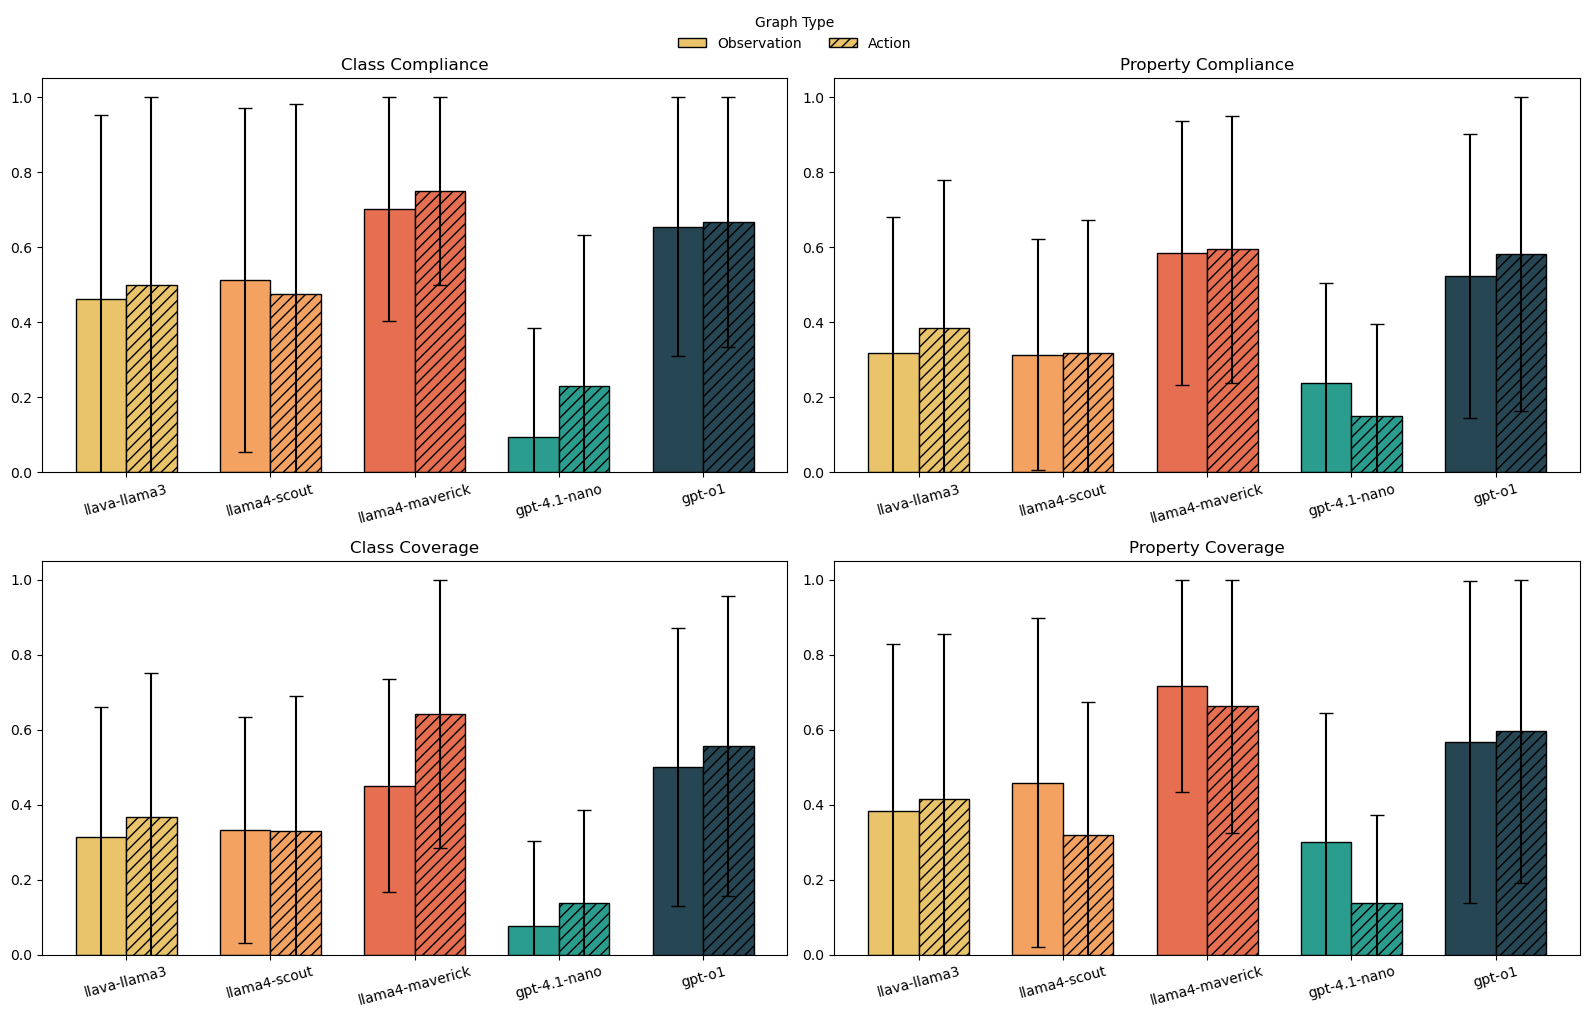

In [42]:
titles = ['Class Compliance', 'Property Compliance', 'Class Coverage', 'Property Coverage']
model_order = list(llm_colors.keys())
types = ['observation', 'action']

grouped = merged_df.groupby(['model', 'graph_type'])[metrics].agg(['mean', 'std'])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
bar_width = 0.35
x = np.arange(len(model_order))
legend_handles = []

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for i, graph_type in enumerate(types):
        means = []
        stds = []
        for model in model_order:
            key = (model, graph_type)
            if key in grouped.index:
                mean = grouped.loc[key][metric]['mean']
                std = grouped.loc[key, metric]['std']
                if pd.notna(std):
                    std = min(std, max(0.0, 1.0 - mean))  # Cap so mean + std ≤ 1.0
                else:
                    std = 0.0
            else:
                mean, std = 0, 0
            means.append(mean)
            stds.append(std)

        offset = (i - 0.5) * bar_width
        bar_positions = x + offset

        bars = ax.bar(
            bar_positions,
            means,
            yerr=stds,
            width=bar_width,
            color=[llm_colors[model] for model in model_order],
            edgecolor='black',
            hatch='///' if graph_type == 'action' else None,
            capsize=5,
            label=graph_type.capitalize() if idx == 0 else None
        )

        if idx == 0:
            legend_handles.append(bars[0])

    ax.set_title(titles[idx])
    ax.set_xticks(x)
    ax.set_xticklabels(model_order, rotation=15)
    ax.set_ylim(0, 1.05)

fig.legend(
    handles=legend_handles,
    labels=[t.capitalize() for t in types],
    loc='upper center',
    ncol=2,
    title='Graph Type',
    frameon=False,
    bbox_to_anchor=(0.5, 1.02)
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()